<a href="https://colab.research.google.com/github/rashidmeras/EVA5/blob/master/S10/EVA5_Submission_Session_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective:

Pick your last code and Add CutOut. It should come from your transformations (albumentations)
* Use this repo: https://github.com/davidtvs/pytorch-lr-finder
* Move LR Finder code to your modules
* Implement LR Finder (for SGD, not for ADAM)
* Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau
* Find best LR to train your model
* Use SDG with Momentum
* Train for 50 Epochs. 
* Show Training and Test Accuracy curves
* Target 88% Accuracy.
* Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.

Submitted By: 
* `Meras Pillai Rashid`
* `Samir Prasad`

## Setup

Import `pytorch` libraries and modules:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Clone the repo

In [2]:
!git clone https://github.com/albumentations-team/albumentations.git

Cloning into 'albumentations'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 4676 (delta 60), reused 40 (delta 23), pack-reused 4584
Receiving objects: 100% (4676/4676), 99.17 MiB | 36.67 MiB/s, done.
Resolving deltas: 100% (3155/3155), done.


In [3]:
!git clone https://github.com/rashidmeras/EVA5.git

Cloning into 'EVA5'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 176 (delta 96), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (176/176), 356.65 KiB | 7.59 MiB/s, done.
Resolving deltas: 100% (96/96), done.


change the code such that it uses GPU

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device : ", device)

Device :  cuda


## Load

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
from albumentations.augmentations.transforms import Normalize, RandomCrop, HorizontalFlip, HorizontalFlip, Rotate, VerticalFlip, Cutout

class AlbumentationImageDataset():
  
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std 
        self.aug = A.Compose([
        HorizontalFlip(p=0.5),
        Rotate(limit=(-10, 10)),
        VerticalFlip(p=0.5),
        Cutout(num_holes = 8, max_h_size = 8, max_w_size = 8),
        Normalize(mean, std),
        ToTensor()
        ])
             
    def __call__(self, image):
        return self.aug(image=np.array(image))['image'] 


def train_test_loader(batch_size = 4, num_workers=2):

    print("\n Initialize train and test loader with Batch Size:{}".format(batch_size))

    torch.manual_seed(22)

    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2023, 0.1994, 0.2010)

    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)
                                  ])   

    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=AlbumentationImageDataset(mean, std))
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, test_loader        

In [6]:
train_loader, test_loader = train_test_loader()
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


 Initialize train and test loader with Batch Size:4


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse   dog   cat plane


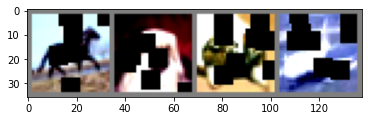

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
from EVA5.Models import ResNet
model = ResNet.ResNet18().to(device)
print("Model Loaded Successfully ")

Model Loaded Successfully 


In [9]:
!pip install torchsummary
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Train

Train for 40 Epochs


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.55E-02


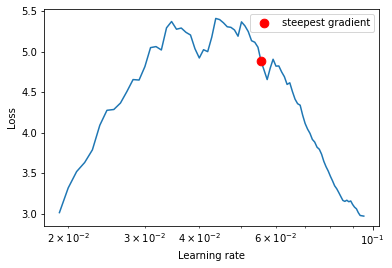

(<matplotlib.axes._subplots.AxesSubplot at 0x7f47281f69e8>,
 0.055454545454545465)

In [10]:
import torch.nn as nn
import torch.optim as optim
from EVA5.S10 import lr_finder

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=1e-5, nesterov=False)
criterion = nn.CrossEntropyLoss()

lrfinder = lr_finder.LRFinder(model, optimizer , criterion , device = "cuda")
lrfinder.range_test(train_loader , end_lr=0.1 , num_iter=100 , step_mode="linear")
lrfinder.plot()

In [11]:
lrfinder.reset()
LR_suggested = 5.55E-02

In [12]:
from datetime import datetime
start_time = datetime.now()

from EVA5.S10 import trainingSetupCifar10
trainingSetupCifar10.initiate_training(model, device, train_loader, LR_suggested, 50)

print('Duration: {}'.format(datetime.now() - start_time))

(*)[1,  2000] loss: 2.338 (*)[1,  4000] loss: 2.111 (*)[1,  6000] loss: 2.011 (*)[1,  8000] loss: 1.908 (*)[1, 10000] loss: 1.821 (*)[1, 12000] loss: 1.773
(*)[2,  2000] loss: 1.706 (*)[2,  4000] loss: 1.672 (*)[2,  6000] loss: 1.616 (*)[2,  8000] loss: 1.582 (*)[2, 10000] loss: 1.547 (*)[2, 12000] loss: 1.521
(*)[3,  2000] loss: 1.463 (*)[3,  4000] loss: 1.429 (*)[3,  6000] loss: 1.412 (*)[3,  8000] loss: 1.393 (*)[3, 10000] loss: 1.315 (*)[3, 12000] loss: 1.317
(*)[4,  2000] loss: 1.278 (*)[4,  4000] loss: 1.236 (*)[4,  6000] loss: 1.227 (*)[4,  8000] loss: 1.216 (*)[4, 10000] loss: 1.175 (*)[4, 12000] loss: 1.129
(*)[5,  2000] loss: 1.116 (*)[5,  4000] loss: 1.086 (*)[5,  6000] loss: 1.095 (*)[5,  8000] loss: 1.083 (*)[5, 10000] loss: 1.059 (*)[5, 12000] loss: 1.040
(*)[6,  2000] loss: 1.005 (*)[6,  4000] loss: 0.996 (*)[6,  6000] loss: 1.010 (*)[6,  8000] loss: 0.975 (*)[6, 10000] loss: 0.969 (*)[6, 12000] loss: 0.956
(*)[7,  2000] loss: 0.931 (*)[7,  4000] loss: 0.932 (*)[7,  6000

## Accuracy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


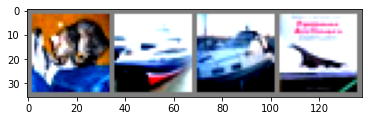

In [13]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Accuracy of the network on the 10000 test images

In [14]:
from EVA5.S7 import cifar10CheckLib
cifar10CheckLib.check_test_accuracy(model, device, test_loader)

Accuracy of the network on the 10000 test images: 85 %


Classwise evaluation

In [15]:
cifar10CheckLib.check_classwise_accuracy(model, device, test_loader, classes)

Accuracy of plane : 89 %
Accuracy of   car : 95 %
Accuracy of  bird : 78 %
Accuracy of   cat : 76 %
Accuracy of  deer : 85 %
Accuracy of   dog : 76 %
Accuracy of  frog : 86 %
Accuracy of horse : 89 %
Accuracy of  ship : 89 %
Accuracy of truck : 91 %


## Summary:

A ResNet18 model was used and Albumination functions were imported to implement transformations including Cutout. LR finder was implemented and best LR was found and the network was trained for 50 epochs.

* Total params: `11,173,962`
* Accuracy of the network on the 10000 test images:  `85%`